In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qecsim.graphtools import blossom5
from pymatching import Matching
import time

In [2]:
##
l = 3 # number of sublattice points (2 for toric code) or primal/dual
Nrep = 1000 # number of iterations
L_list = [8]#,10,12]
p1_list = np.linspace(0.002,0.05,10)
# p2 = 0.003
fail_prob_z0 = np.zeros((len(L_list),len(p1_list)))

for i_L, r in enumerate(L_list):
    print("L= ", r)
    tic = time.time()
    r1 = r # dimension of cube
    r2 = r # dimension of cube
    r3 = r # dimension of cube

    # star stabilzers
    Sx = np.zeros((r1*r2*r3,l*r1*r2*r3))
    for ix in range(r1):
        for iy in range(r2):
            for iz in range(r3):
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+1] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+2] = 1
                Sx[ix + r1*(iy+ r2*iz), l*( ((ix-1)%r1) + r1*(iy+ r2*iz))] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*( ((iy-1)%r2)+ r2*iz) )+1] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2* ((iz-1)%r3)) )+2] = 1

    logicals = np.zeros((3,l*r1*r2*r3))
    ## x ops
    for i1 in range(r2):
        logicals[0,np.ix_(3*np.arange(i1*r1,r1*r2*r3,r1*r2))] = np.ones(r3)
    for i1 in range(r3):
        logicals[1,np.ix_(1+ 3*(i1*r1*r2+ np.arange(0,r1) ) )] = np.ones(r1)
    logicals[2,2:3*r1*r2+1:3] = np.ones(r1*r2) 


    # print(np.dot(logicals,logicals.T))
    for i_p, p1 in enumerate(p1_list):
        # z flip error
        p2 = p1
        prob_x_axis = (2+2/3)*p1 + 40/15*p2
        prob_y_axis = 2*p1 + 32/15*p2
        prob_z_axis = prob_y_axis
        p2_x = 12/15*p2
        p2_y = 4/15*p2
        p2_z = p2_y

        num_qubits = l*r1*r2*r3
        weights = np.zeros(num_qubits)
        weights[0:num_qubits:3] = np.log((1-prob_x_axis)/prob_x_axis)
        weights[1:num_qubits:3] = np.log((1-prob_y_axis)/prob_y_axis)
        weights[2:num_qubits:3] = np.log((1-prob_z_axis)/prob_z_axis)
        m_orig = Matching(Sx,spacelike_weights=weights)

        for i_n in range(Nrep):
            error_tot = np.zeros(l*r1*r2*r3,dtype=int)
            
            error_x = np.random.rand(r1*r2*r3) 
            zflip_x_inds = np.argwhere(error_x < prob_x_axis)
            error_tot[3*zflip_x_inds] = 1
            
            error_y = np.random.rand(r1*r2*r3) 
            zflip_y_inds = np.argwhere(error_y < prob_y_axis)
            error_tot[3*zflip_y_inds+1] = 1

            error_z = np.random.rand(r1*r2*r3) 
            zflip_z_inds = np.argwhere(error_z < prob_z_axis)
            error_tot[3*zflip_z_inds+2] = 1
            
            corr_err_x_z = np.random.rand(r1*r2*r3)
            zflip_x_inds = np.argwhere(corr_err_x_z < p2_x)
            x2 = ((zflip_x_inds%(r1*r2))%r1) 
            y2 = np.floor((zflip_x_inds%(r1*r2))/r1)
            z2 = (np.floor(zflip_x_inds/(r1*r2))+1)%r3
            q2 = (z2*r2+y2)*r1 + x2
            error_tot[3*zflip_x_inds] += 1
            error_tot[3*q2.astype(int)] += 1

            corr_err_x_y = np.random.rand(r1*r2*r3) 
            zflip_x_inds = np.argwhere(corr_err_x_y < p2_x)
            x2 = ((zflip_x_inds%(r1*r2))%r1) 
            y2 = (np.floor((zflip_x_inds%(r1*r2))/r1)+1)%r2
            z2 = np.floor(zflip_x_inds/(r1*r2))       
            q2 = (z2*r2+y2)*r1 + x2
            error_tot[3*zflip_x_inds] += 1
            error_tot[3*q2.astype(int)] += 1

            corr_err_y_z = np.random.rand(r1*r2*r3) 
            zflip_y_inds = np.argwhere(corr_err_y_z < p2_y)
            x2 = ((zflip_y_inds%(r1*r2))%r1) 
            y2 = np.floor((zflip_y_inds%(r1*r2))/r1)
            z2 = (np.floor(zflip_y_inds/(r1*r2))+1)%r3
            q2 = (z2*r2+y2)*r1 + x2
            error_tot[3*zflip_y_inds+1] += 1
            error_tot[3*q2.astype(int)+1] += 1

            corr_err_z_y = np.random.rand(r1*r2*r3) 
            zflip_z_inds = np.argwhere(corr_err_z_y < p2_z)
            x2 = ((zflip_z_inds%(r1*r2))%r1) 
            y2 = (np.floor((zflip_z_inds%(r1*r2))/r1)+1)%r2
            z2 = np.floor(zflip_z_inds/(r1*r2))       
            q2 = (z2*r2+y2)*r1 + x2
            error_tot[3*zflip_z_inds+2] += 1
            error_tot[3*q2.astype(int)+2] += 1

            error_tot %= 2 
            # find syndrome
            syndrome_x = np.dot(error_tot,Sx.T) % 2
            rec_x = m_orig.decode(syndrome_x)

            np.dot( (rec_x + error_tot )%2 , logicals.T) % 2

            assert np.sum(np.dot( (rec_x + error_tot )%2 , Sx.T) % 2) == 0

            ###########
            if np.sum(np.dot( (rec_x + error_tot )%2, logicals.T) %2)  > 0:
                fail_prob_z0[i_L,i_p] +=  1
    toc = time.time()
    print("Finished in %d secs" % (toc-tic))

print("Done!")

L=  8
Finished in 96 secs
Done!


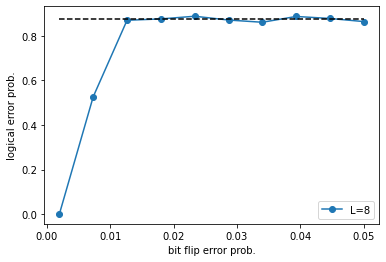

In [3]:
for i_L, L in enumerate(L_list):
    plt.plot(p1_list,fail_prob_z0[i_L,:]/Nrep,"o-", label="L=%d" % (L))
    
plt.plot(p1_list, 1-1/8+0*p1_list,"k--")
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
# plt.yscale("log")
plt.legend()
plt.show()

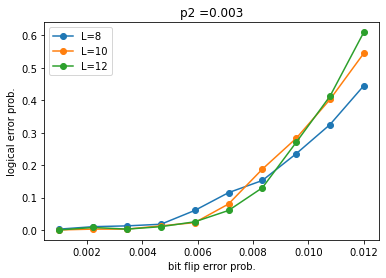

In [49]:
for i_L, L in enumerate(L_list):
    plt.plot(p1_list,fail_prob_z0[i_L,:]/Nrep,"o-", label="L=%d" % (L))
    
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
plt.title("p2 =%.3f" % (p2))
# plt.yscale("log")
plt.legend()
plt.show()

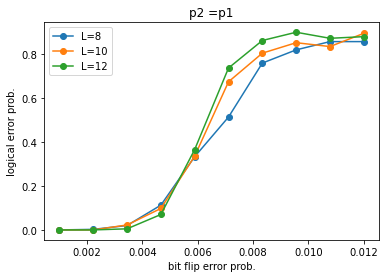

In [51]:
for i_L, L in enumerate(L_list):
    plt.plot(p1_list,fail_prob_z0[i_L,:]/Nrep,"o-", label="L=%d" % (L))
    
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
plt.title("p2 =p1")
# plt.yscale("log")
plt.legend()
plt.show()

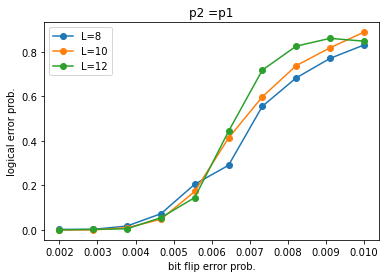

In [56]:
for i_L, L in enumerate(L_list):
    plt.plot(p1_list,fail_prob_z0[i_L,:]/Nrep,"o-", label="L=%d" % (L))
    
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
plt.title("p2 =p1")
# plt.yscale("log")
plt.legend()
plt.show()

In [57]:
print((2+2/3)+40/15, 2 + 32/15)

5.333333333333333 4.133333333333333
